# Report computer vision project
Project link: https://github.com/TQNLP/POVa-Automatic_text_transcription_OCR

## Topic definition
Handwriting Sentence Recognition involves the automated interpretation of handwritten text using Python-based algorithms and machine learning techniques. This technology holds immense significance in various domains, facilitating the digitization of historical documents, aiding in data entry automation, and enabling accessibility for handwriting-impaired individuals.

## Technical solution
The biggest challenge in handwritten text recognition is handwriting variability. All of us have different handwriting styles and even the same person’s handwriting style can vary. There are various techniques and methods to address this problem. We will follow precise steps to solve this problem :
1) Load the IAM Handwriting Database and preprocess the data
2) Load the pre-trained text recognition model from Hugging Face using the transformers library.
3) Create the  class IAMDataset to handle loading and processing of IAM.
4) Fine-tune the pre-trained model on the dataset.
5) Evaluate the model on a validation set to assess its performance.

## Documentation
We based our approach on a pre-trained model of Hugging Face community.
The dataset used are from IAM-lines (https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database)

Hugging Face text recognition documentation:
https://huggingface.co/docs/transformers/model_doc/trocr

Information about handwritten text recognition :
https://www.v7labs.com/blog/handwriting-recognition-guide#:~:text=A%20handwriting%20recognition%20system%20also,Optical%20Character%20Recognition%20(OCR).


In [1]:
import platform

def definePathWithOS():
    current_os = platform.system()
    if current_os == 'Windows':
        return ".\\dataset\\sum_meta\\",  ".\\dataset\\IAM-lines\\"
    else:
        return "./dataset/sum_meta",  "./dataset/IAM-lines/"

file_path, dataset_path = definePathWithOS()
print(file_path, dataset_path)

./dataset/sum_meta ./dataset/IAM-lines/


In [2]:
import os
from sklearn.model_selection import train_test_split

def preprocess_dataset(file_path, dataset_path):
    dataset, vocab, max_len = [], set(), 0
    # We will use IAM lines dataset
    sentences = open(os.path.join(file_path, "lines.txt"), "r").readlines()
    for line in sentences:
        if line.startswith("#"):
            continue

        line_split = line.split(" ")
        if line_split[1] == "err":
            continue

        folder1 = line_split[0][:3]
        folder2 = line_split[0][:8]
        file_name = line_split[0] + ".png"
        label = line_split[-1].rstrip('\n')

        label = label.replace('|', ' ')
        rel_path = os.path.join(dataset_path, folder1, folder2, file_name)

        if not os.path.exists(rel_path):
            continue

        dataset.append([rel_path, label])
        vocab.update(list(label))
        max_len = max(max_len, len(label))

    # Splitting the dataset into training and validation sets
    train_values, test_values = train_test_split(
        dataset, test_size=0.2, random_state=42)

    return train_values, test_values, max_len, vocab

train_values, test_values, max_len, vocab = preprocess_dataset(
        file_path, dataset_path)
print(train_values, test_values)

[['./dataset/IAM-lines/a01/a01-049u/a01-049u-04.png', 'Communist affiliations . The Senate Banking'], ['./dataset/IAM-lines/g06/g06-011m/g06-011m-01.png', 'Naples . He told Cloncurry that he enjoyed it as'], ['./dataset/IAM-lines/c03/c03-096e/c03-096e-01.png', 'explicably from appreciable motives . The'], ['./dataset/IAM-lines/g06/g06-050c/g06-050c-05.png', 'with a gentle and charming character , even-tempered'], ['./dataset/IAM-lines/a01/a01-043u/a01-043u-00.png', 'Informal talks at Lancaster House will'], ['./dataset/IAM-lines/g07/g07-022a/g07-022a-05.png', 'is a pleasing , fine looking young man &'], ['./dataset/IAM-lines/g06/g06-042a/g06-042a-02.png', 'the 6tic douloureux . As early as 1830 , when'], ['./dataset/IAM-lines/g06/g06-011b/g06-011b-06.png', 'is going out fast ... . What a gay , lively'], ['./dataset/IAM-lines/g06/g06-047c/g06-047c-03.png', "a human being ' , had an increasing number of"], ['./dataset/IAM-lines/g06/g06-037l/g06-037l-00.png', 'God grant , however , that I

In [3]:
# IAM dataset implementation is based on Hugging Face documentation
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, df, processor, max_target_length=128):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df[idx][0]
        text = self.df[idx][1]
        # prepare image (i.e. resize + normalize)
        image = Image.open(file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values, "labels": torch.tensor(labels)}
        return encoding

# We use a pretrained model from Hugging Face

from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(train_values, processor)
test_dataset = IAMDataset(test_values, processor)

2023-12-23 23:17:43.715987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [4]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(test_dataset))

Number of training examples: 2022
Number of validation examples: 506


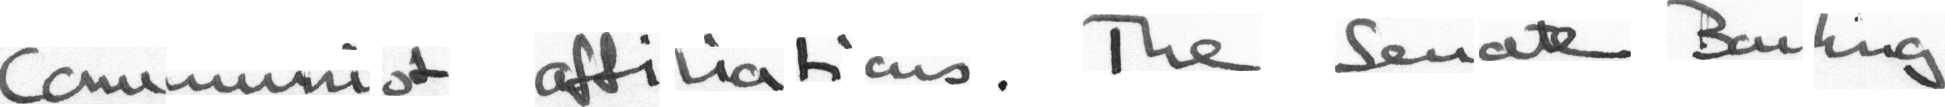

In [5]:
# Example showcase

image = Image.open(train_values[0][0]).convert("RGB")
image

In [6]:
encoding = train_dataset[0]
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Communist affiliations. The Senate Banking


In [7]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [8]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [9]:
from datasets import load_metric

cer_metric = load_metric("cer")

/var/folders/zn/glg9n34x2rlg_nkrw77_z1nc0000gn/T/ipykernel_13681/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/usr/local/lib/python3.11/site-packages/datasets/load.py:752: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [10]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from torch.utils.data import DataLoader
import torch

# Define a device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training parameters
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        # Move batch to device
        pixel_values = batch['pixel_values'].squeeze().to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {loss.item()}")
    
model.save_pretrained("./modelsave")


/usr/local/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


In [12]:
model = VisionEncoderDecoderModel.from_pretrained("./modelsave")
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

/usr/local/lib/python3.11/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Communist affiliations. The Senate Banking


In [14]:
from tqdm.notebook import tqdm

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
valid_cer = 0.0
with torch.no_grad():
      for batch in tqdm(test_loader):
         pixel_values = batch['pixel_values'].squeeze().to(device)
         labels = batch['labels'].to(device)
         # run batch generation
         outputs = model.generate(pixel_values.to(device))
         # compute metrics
         cer = compute_cer(pred_ids=outputs, label_ids=labels)
         valid_cer += cer 
      print("Validation CER:", valid_cer / len(test_loader))

  0%|          | 0/127 [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
